In [5]:
import numpy as np
from misc import *
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os 

ppp = 500
periods = 40


gamma = 1 #damping from outside
Gamma = 1 #measurement rate
eta = 1 # measurement efficiency
n = 2 # number of photons?

w = 2*np.pi
T = (2*np.pi)/w


C = np.array([[np.sqrt(4*eta*Gamma), 0] ,[0, np.sqrt(4*eta*Gamma)]])

A = np.array([
    [0., w],
    [-w, 0.]])

D = np.array([[gamma*(n + 0.5) + Gamma, 0], [0,gamma*(n + 0.5) + Gamma]])

su = n + 0.5 + Gamma/gamma
cov_in = np.array([[np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma), 0],
                   [0,np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]])


xi = lambda cov: np.dot(cov, ct(C)) + ct(D)

parameters = np.linspace(-1,1,101) + 2*np.pi

give_pred = lambda state: np.dot(C,state)*dt
def evolve_state(states, AA, dy):
    x, cov = states
    XiCov = xi(cov)
    dx = np.dot(AA - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(AA,cov) + np.dot(cov, ct(AA)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]

itraj = 0 

In [ ]:
def dxdt(

In [ ]:

for seed in range(30):
    np.random.seed(seed)
    landscape = {}
    for periods in [1,5,10,30,40]:

        dt = T/ppp
        total_points = int(periods*ppp)

        signals = []

        covs = [cov_in]
        means = [np.array([1.,0.])] ## initial condition
        xicovs = [xi(covs[-1])]

        symplectic = np.array([[0,1],[-1,0]])
        predictions, states = {t:[] for t in range(len(parameters))},{t:[[means[0], covs[0]]] for t in range(len(parameters))}
        signals=[]

        for k in tqdm(range(total_points)):
            x = means[-1]
            cov = covs[-1]
            XiCov = xi(cov)

            dy = np.dot(C, x + np.dot(np.linalg.pinv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
            signals.append(dy)

            dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
            dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update

            covs.append(covs[-1] + dcov)
            means.append(means[-1] + dx)

            for i in range(len(parameters)):
                predictions[i].append(give_pred(states[i][-1][0]))
                states[i].append(evolve_state(states[i][-1], parameters[i]*symplectic, dy))

        means = np.array(means)
        covs = np.array(covs)
        xicovs = np.array(xicovs)
        signals = np.array(signals)
        coeffs = [C, A, D , dt]

        loss = {}

        for i in range(len(parameters)):
            loss[i] = np.sum(np.square(np.array(predictions[i]) - np.array(signals)))/(2*dt*len(predictions[i]))
        landscape[periods] = list(loss.values())

        path = get_def_path()
        path = path + "landscape/{}/{}periods/{}ppp/".format(seed,periods,ppp)
        os.makedirs(path+"{}/".format(itraj), exist_ok=True)
        np.save(path+"{}/m]eans".format(itraj),np.array(means) )
        np.save(path+"{}/covs".format(itraj),np.array(covs) )
        np.save(path+"{}/signals".format(itraj),np.array(signals) )
        np.save(path+"{}/xicovs".format(itraj),np.array(xicovs) )
        np.save(path+"{}/D".format(itraj),D)
        np.save(path+"{}/C".format(itraj),C)
        np.save(path+"{}/dt".format(itraj),np.array([dt]))
        np.save(path+"{}/A".format(itraj),A)
        for k,p in loss.items():
            np.save(path+"loss_{}".format(k), p)
        for k,p in predictions.items():
            np.save(path+"preds_{}".format(k), p)


 78%|███████▊  | 15521/20000 [05:35<02:10, 34.38it/s]

In [3]:
for i,k in landscape.items():
    os.makedirs(get_def_path()+"visualize/",exist_ok=True)
    np.save(get_def_path()+"visualize/lanscape_".format(i),k)



In [8]:
parameters

array([ 0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
        1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339,
        3.14159265,  3.45575192,  3.76991118,  4.08407045,  4.39822972,
        4.71238898,  5.02654825,  5.34070751,  5.65486678,  5.96902604,
        6.28318531,  6.59734457,  6.91150384,  7.2256631 ,  7.53982237,
        7.85398163,  8.1681409 ,  8.48230016,  8.79645943,  9.1106187 ,
        9.42477796,  9.73893723, 10.05309649, 10.36725576, 10.68141502,
       10.99557429, 11.30973355, 11.62389282, 11.93805208, 12.25221135])

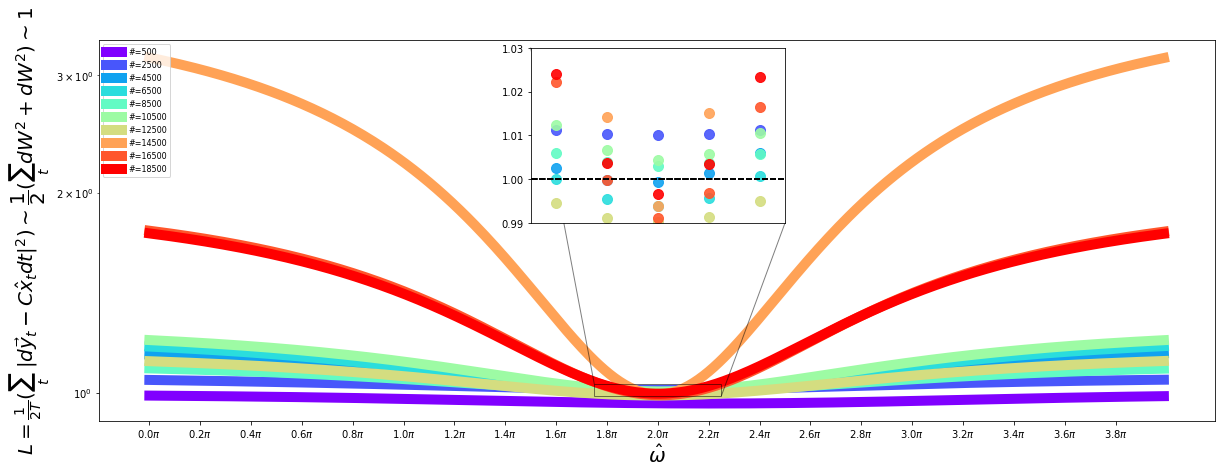

In [24]:
plt.figure(figsize=(20,7))

colors = plt.get_cmap("rainbow")
ax = plt.subplot2grid((1,1),(0,0))
axins = ax.inset_axes([2*np.pi - np.pi/2, 1.8, np.pi, 1.5],  transform=ax.transData)
axins.set_xticks([])

for ind,i in enumerate(list(landscape.keys())):
    ax.plot(parameters,landscape[i],'.-', linewidth=10, alpha=1,color=colors(np.linspace(0,1,len(landscape)))[ind], label="#={}".format(i*ppp))
    ax.set_xticks(ticks=parameters[0:-1:20])
    ax.set_xticklabels([str(np.round(p/np.pi,1))+r'$\pi$' for p in parameters[0:-1:20]])
    ax.set_yscale('log')
    axins.scatter(parameters[0:-1:10],landscape[i][0:-1:10],s=100, alpha=.9,color=colors(np.linspace(0,1,len(landscape)))[ind])
    axins.plot(parameters[0:-1:10],np.ones(len(landscape[i][0:-1:10])),'--',color="black")
    
    axins.set_xlim([2*np.pi - np.pi/4, 2*np.pi + np.pi/4])
    axins.set_ylim([.99,1.03])
    
plt.legend(prop={"size":8}, loc='upper left')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.xlabel(r'$\hat{\omega}$',size=20)
plt.ylabel(r'$L = \frac{1}{2 T}(\sum_t \; |d\vec{y}_t - C\hat{x}_t dt|^2) \sim \dfrac{1}{2} (\sum_t dW^2 + dW^2) \sim 1$', size=20)
plt.savefig("landscape_numpy.png")